In [1]:
train_initial_data = './Datasets/train_data_converted_json_to_csv1_0.csv'
train_data_sampled = './Datasets/train_data_sampled.csv'

In [2]:
!pip install transformers

In [3]:
!pip install -U scikit-learn scipy matplotlib
!pip install pandas
!pip install seaborn
!pip install nltk

In [4]:
import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer,BertModel,AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
from argparse import ArgumentParser
import warnings  
warnings.filterwarnings('ignore')

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

In [6]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
import pandas as pd

df = pd.read_csv(train_initial_data)

In [9]:
print(len(df))

28986


In [10]:
df.head()

,start,end,text,labels
0,0,116,"IN THE HIGH COURT OF KARNATAKA,\n ...",['PREAMBLE']
1,116,678,\n\n BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...,['PREAMBLE']
2,678,964,This Criminal Appeal is filed under Section 37...,['PREAMBLE']
3,964,1093,\n\n This appeal coming on for hearing t...,['PREAMBLE']
4,1093,1180,\n Heard the learned Counsel for the app...,['NONE']


In [11]:
data_df = df
print(data_df.head())

   start   end                                               text  \
0      0   116        IN THE HIGH COURT OF KARNATAKA,\n       ...   
1    116   678  \n\n      BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...   
2    678   964  This Criminal Appeal is filed under Section 37...   
3    964  1093  \n\n       This appeal coming on for hearing t...   
4   1093  1180  \n       Heard the learned Counsel for the app...   

         labels  
0  ['PREAMBLE']  
1  ['PREAMBLE']  
2  ['PREAMBLE']  
3  ['PREAMBLE']  
4      ['NONE']  


In [12]:
df['text'][0]

'      IN THE HIGH COURT OF KARNATAKA,\n          CIRCUIT BENCH AT GULBARGA\n\nDATED THIS THE 22ND DAY OF FEBRUARY, 2013'

In [13]:
print(len(df))

28986


In [14]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /soe/parikshithh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /soe/parikshithh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
#Data preprocessing function
import re
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
def preprocess(data_df):
  data_df['text'] = data_df['text'].apply(lambda t: t.lower()) #Convert to lower
  data_df['text'] = data_df['text'].apply(lambda t: re.sub("\n", ' ', t)) #Remove new line 
  data_df['text'] = data_df['text'].apply(lambda t: re.sub(r'\.{2,}','.', t)) #regular expression for normalizing repeated ... patterns
  data_df['text'] = data_df['text'].apply(lambda t: re.sub(r'[\"\"#\$%&\(\)\*\+,-/:;<=>\@\[\\\]\^_`{\|}~]', ' ', t)) #remove punctuations
  data_df['text'] = data_df['text'].apply(lambda t: re.sub('"', '', t)) #remove redundant ""
  data_df['text'] = data_df['text'].str.replace('\d+', '') #remove numbers
  data_df['text'] = data_df['text'].str.strip() #remove extra spaces
  data_df['text'] = data_df['text'].apply(lambda t: ' '.join(t.strip().split()))
  data_df['labels'] = data_df['labels'].str.replace(r'[\[\]\'\']', '') #remove punctuations from labels
  data_df['text'] = data_df['text'].str.replace(' +$', '')  #remove extra spaces at end
  data_df['labels'] = data_df['labels'].apply(lambda t: t.lower()) #convert to lower of labels
  data_df['text'] = data_df['text'].apply(lambda t: ' '.join([t for t in nltk.word_tokenize(t) if t.lower() not in stop_words])) #removal of stop words and tokenization
  return data_df

In [16]:
new_data_df_1= preprocess(data_df)

In [17]:
new_data_df_1.head()

,start,end,text,labels
0,0,116,high court karnataka circuit bench gulbarga da...,preamble
1,116,678,hon'ble mr justice anand byrareddy criminal ap...,preamble
2,678,964,criminal appeal filed section code criminal pr...,preamble
3,964,1093,appeal coming hearing day court delivered foll...,preamble
4,1093,1180,heard learned counsel appellant learned govern...,none


In [18]:
new_data_df_1['text'][0]

'high court karnataka circuit bench gulbarga dated nd day february'

In [19]:
print(new_data_df_1['labels'][0])

preamble


In [20]:
print(len(new_data_df_1))

28986


{'analysis': 10695, 'fac': 5744, 'preamble': 4167, 'pre_relied': 1431, 'none': 1423, 'arg_petitioner': 1315, 'rpc': 1081, 'rlc': 752, 'arg_respondent': 698, 'ratio': 674, 'sta': 481, 'issue': 367, 'pre_not_relied': 158}


<AxesSubplot: title={'center': 'Number of Occurrence of each tags'}>

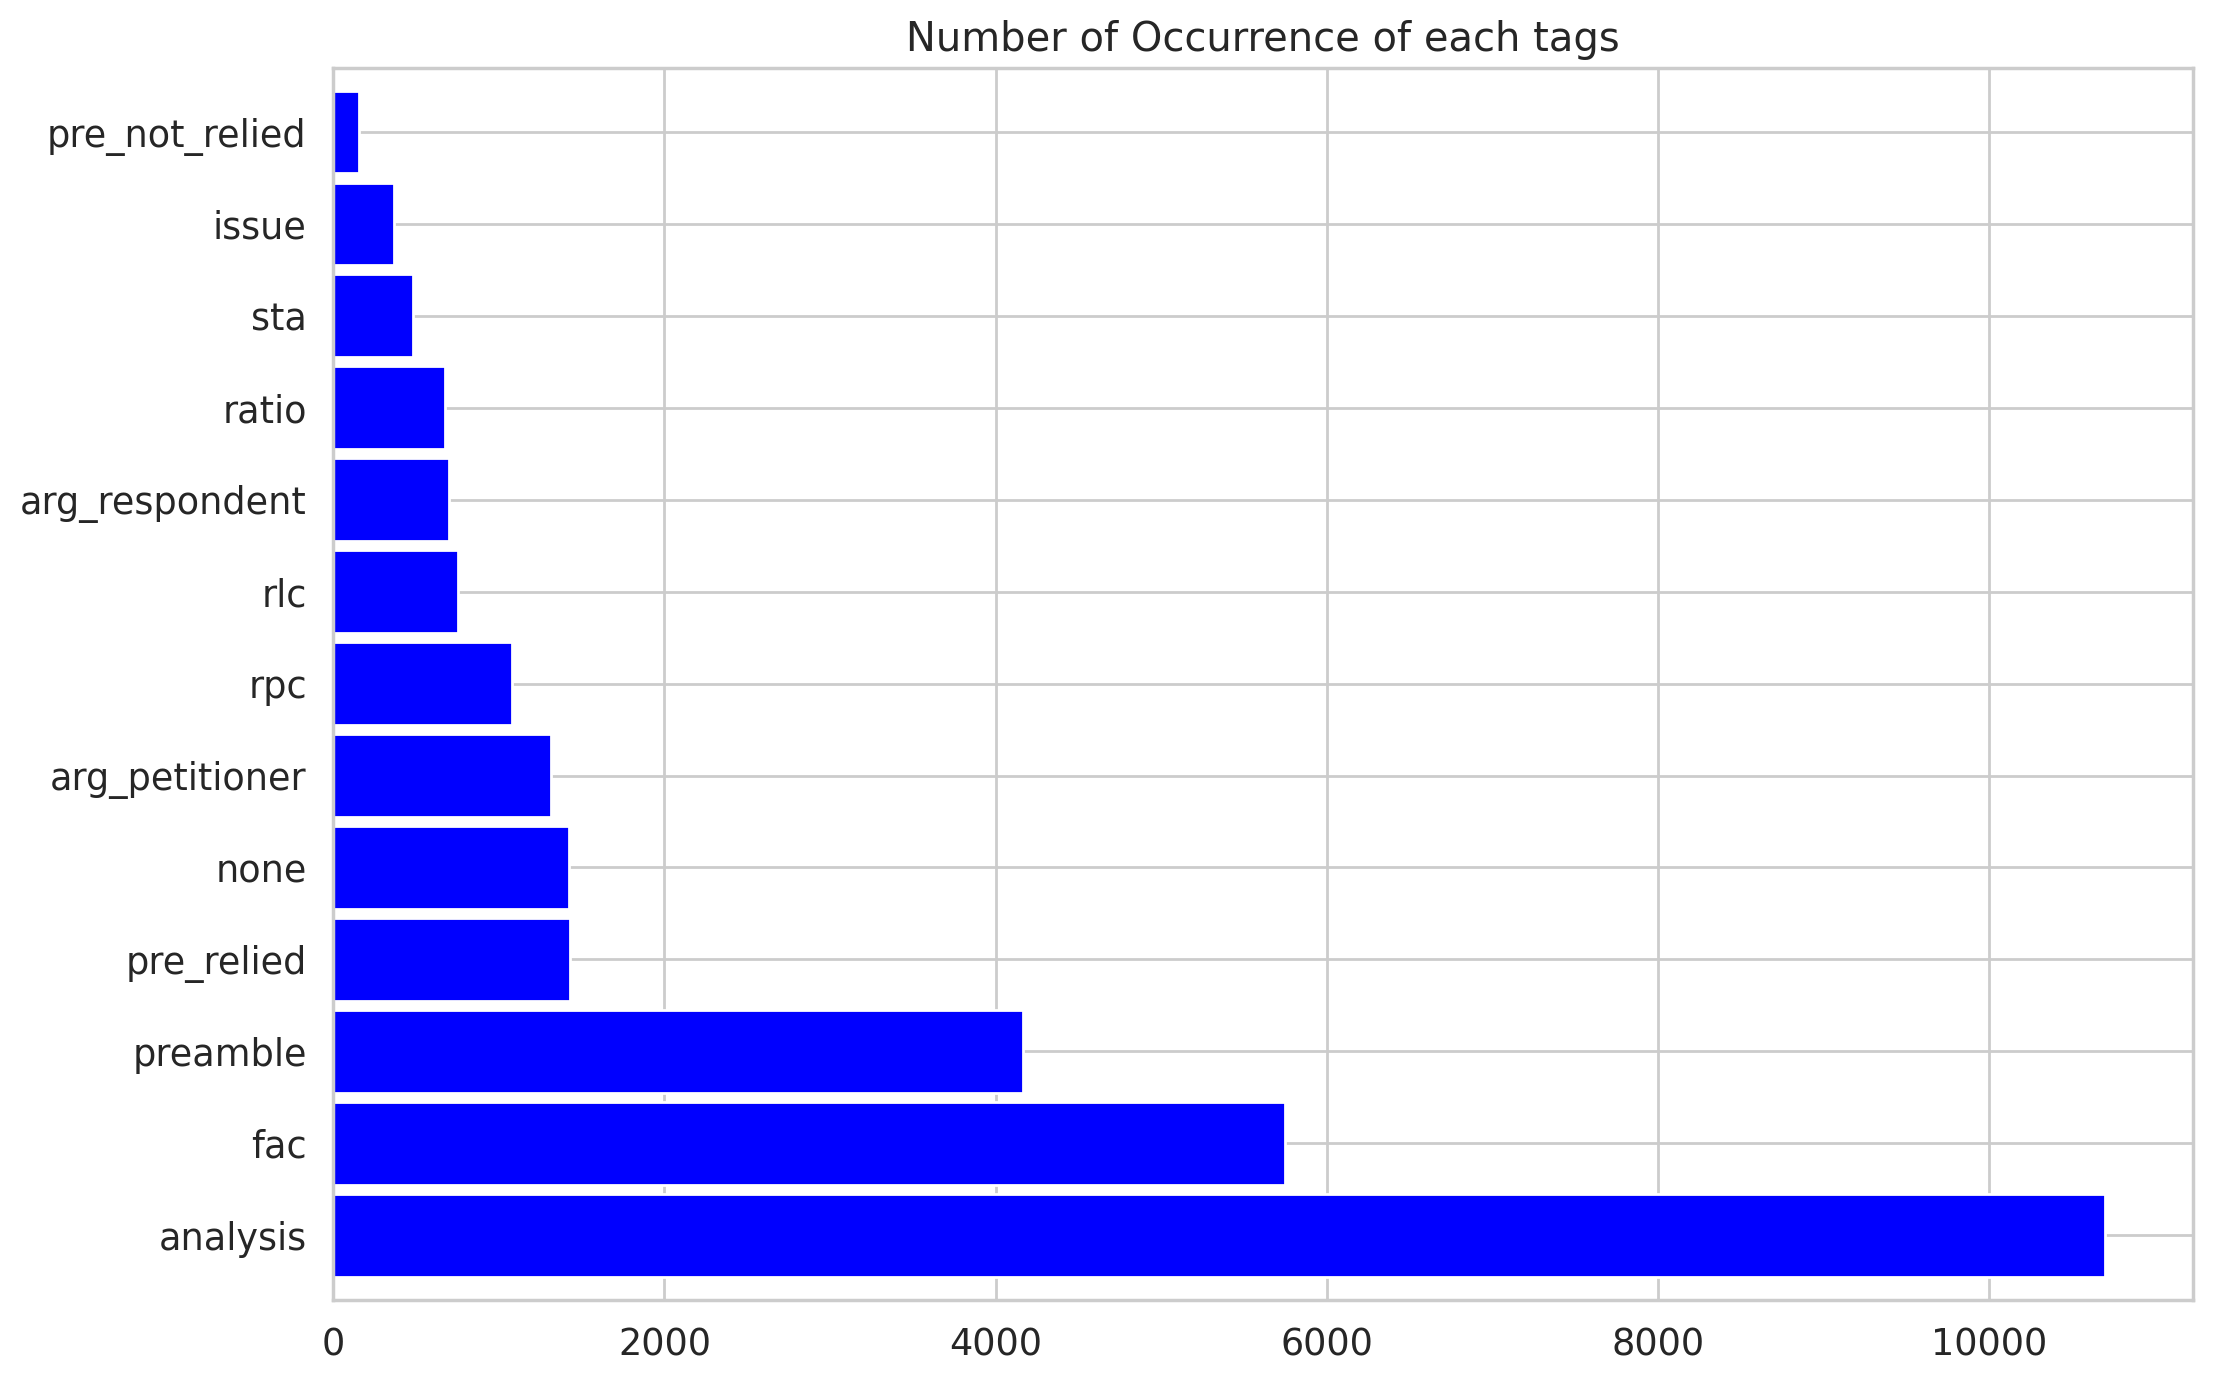

In [21]:
labels_print = new_data_df_1['labels']
labels_print_count = labels_print.explode().value_counts()
print(dict(labels_print_count))
labels_print_count.plot(kind="barh", width=0.9, color="blue", title="Number of Occurrence of each tags")

In [22]:
new_data_df = new_data_df_1

In [23]:
new_data_df

,start,end,text,labels
0,0,116,high court karnataka circuit bench gulbarga da...,preamble
1,116,678,hon'ble mr justice anand byrareddy criminal ap...,preamble
2,678,964,criminal appeal filed section code criminal pr...,preamble
3,964,1093,appeal coming hearing day court delivered foll...,preamble
4,1093,1180,heard learned counsel appellant learned govern...,none
...,...,...,...,...
28981,21494,21601,section evidence act sufficiently protects sin...,ratio
28982,21601,21652,reasons aforesaid appeal allowed,rpc
28983,21653,21761,judgment order dated april passed revision pet...,rpc
28984,21761,21769,r,none


In [24]:
# testing of tokenizer

tokens = tokenizer.tokenize(new_data_df['text'][0])
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(tokenizer)
print(token_ids)

print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})
[2152, 2457, 12092, 4984, 6847, 19739, 20850, 2906, 3654, 6052, 1050, 2094, 2154, 2337]
[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [25]:
#Getting tokens count
token_lens = []
for txt in new_data_df.text:
  tokens = tokenizer.encode(str(txt), max_length=512, truncation=True)
  token_lens.append(len(tokens))

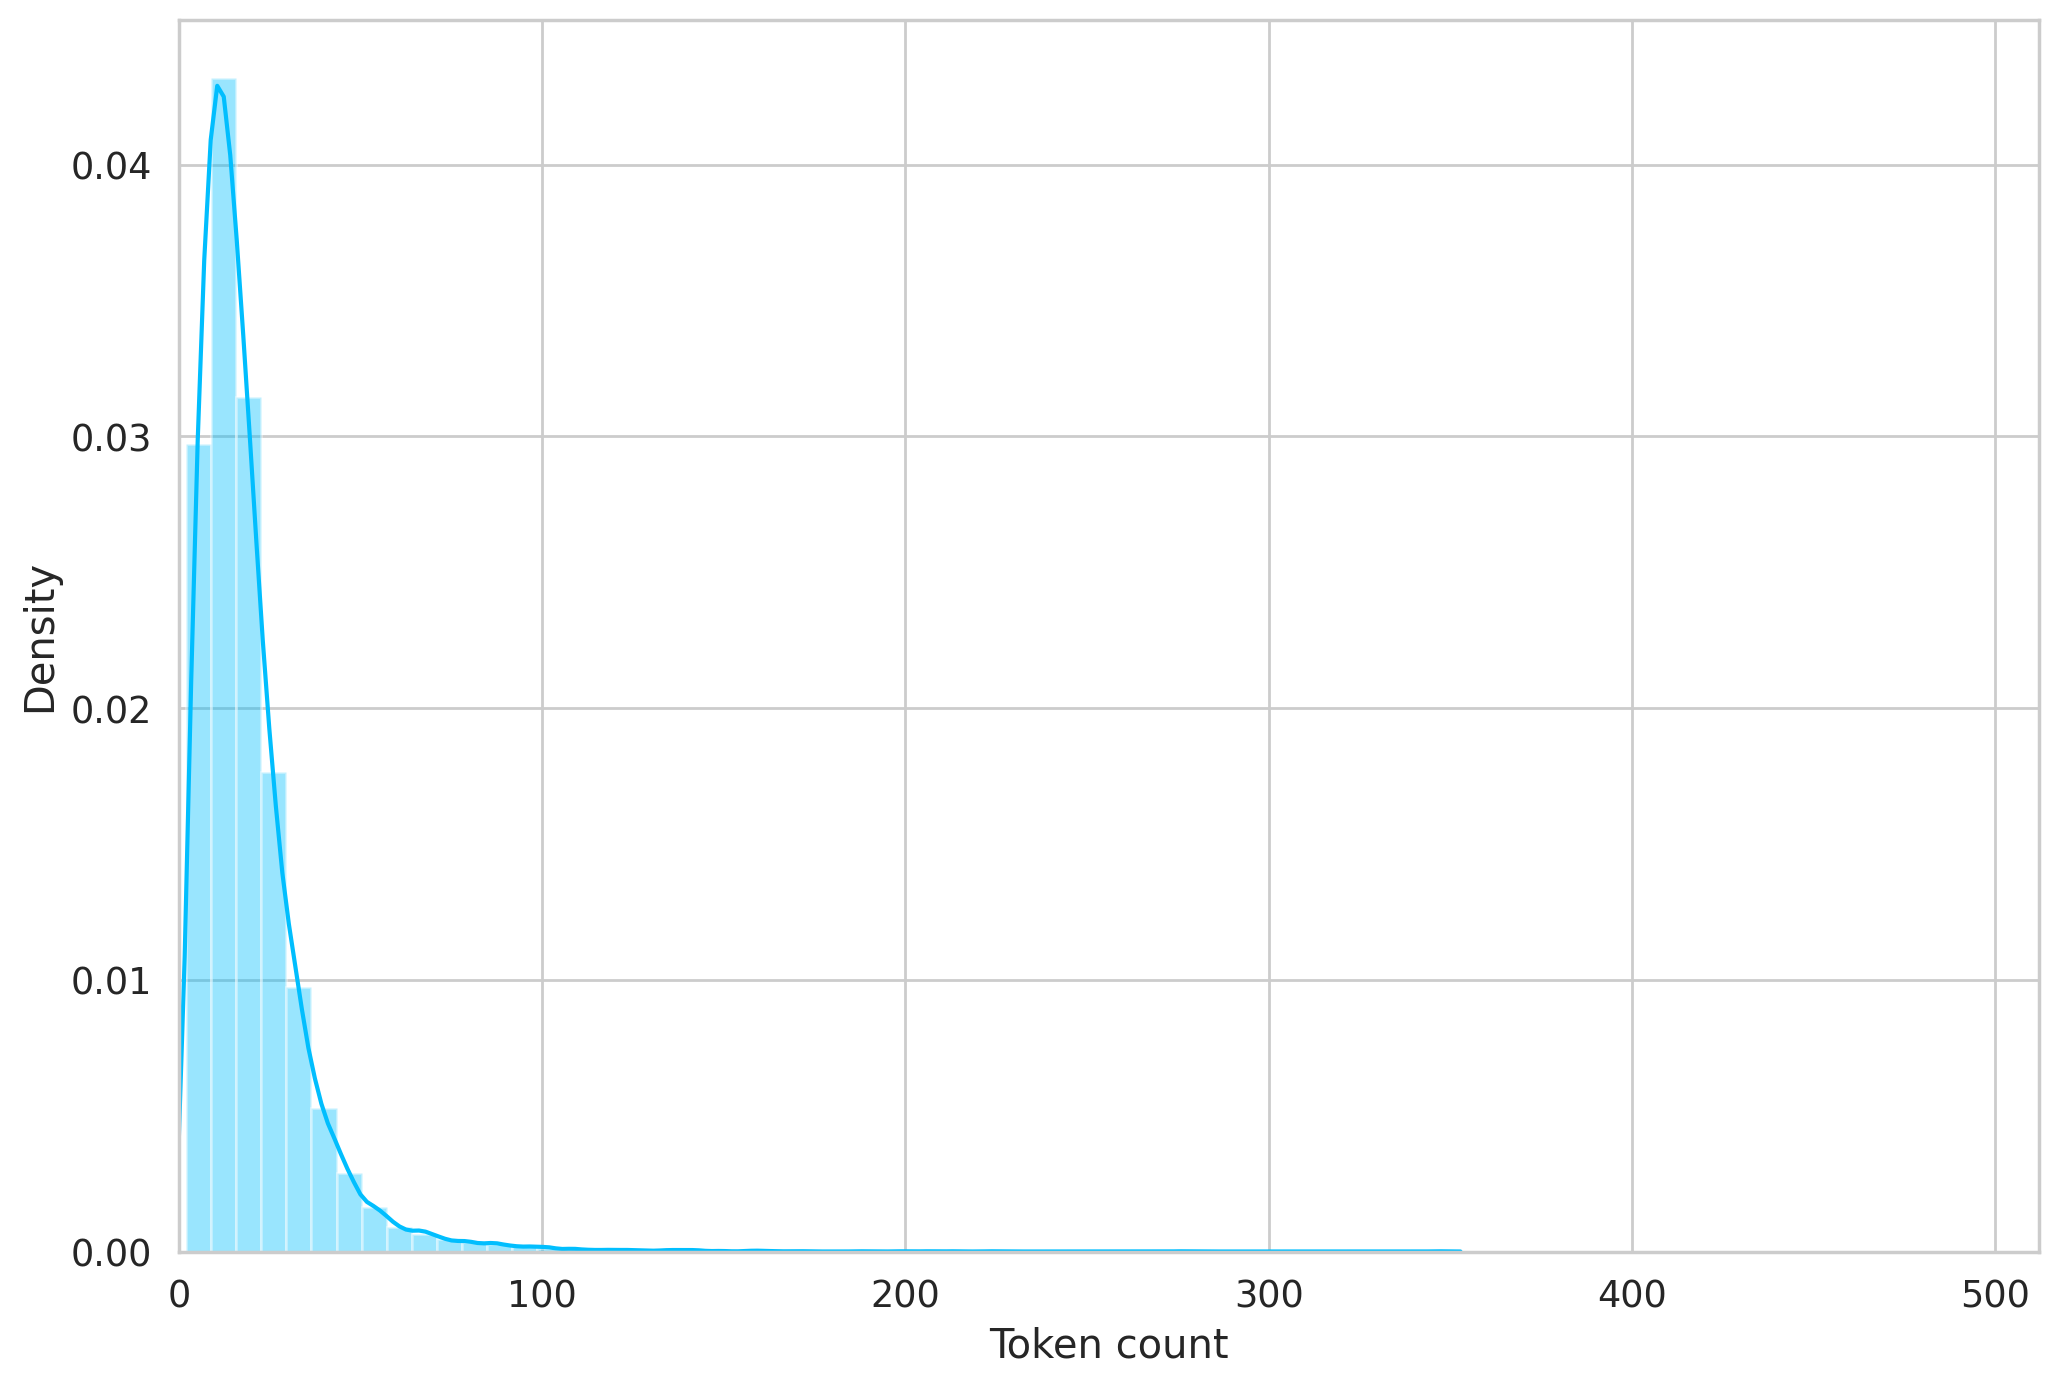

In [26]:
#Getting maximum tokens count plot
sns.distplot(token_lens)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [27]:
max_l = max(token_lens)
print(max_l)

347


#classes


In [28]:
# getting labels list
labels_list=[]

for i in new_data_df.labels:
  labels_list.append(i)

labels_set = set(labels_list)
print(labels_set)


{'analysis', 'preamble', 'pre_relied', 'rpc', 'issue', 'arg_petitioner', 'sta', 'pre_not_relied', 'ratio', 'arg_respondent', 'none', 'rlc', 'fac'}


In [29]:
# index to labels
itol ={}
ltoi ={}
ind =0
for i in labels_set:
  itol[ind]=i
  ltoi[i]= ind
  ind =ind+1


In [30]:
for i in range(0,len(new_data_df)):
  new_data_df.loc[i,["labels"]]=ltoi[new_data_df["labels"][i]]

# dataset

In [31]:
#Dataset class to load the data and convert into tensor
class Legaleval(Dataset): 
  def __init__(self, text, targets, tokenizer, max_len):
    self.content = text #sentence converted to indices list
    self.targets = targets # lables 
    self.tokenizer = tokenizer # BERT tokenizer
    self.max_len = max_len # maximum tokem count found among all the sentences in the datasets

  def __len__(self):
    return len(self.content) # here content represents the text  

  def __getitem__(self, item): #getting an encoded item
    text = str(self.content[item])# getting the sentence 
    target = self.targets[item] # label 
    # encoding the sentence using inbulit encode_plus from Bert
    encoding = self.tokenizer.encode_plus(text,add_special_tokens=True,max_length=self.max_len,return_token_type_ids=False,pad_to_max_length=True,return_attention_mask=True,return_tensors='pt',truncation=True)
    return {
      'Legal_text': text, # text used to find encoding
      'input_ids': encoding['input_ids'].flatten(),# encoded the indices of the tokens from the given sentence
      'attention_mask': encoding['attention_mask'].flatten(),# attention layer
      'targets': torch.tensor(target, dtype=torch.long)# converting the lables lists to tensor
    }

In [32]:
#Spliting of Dataset
from sklearn.model_selection import train_test_split # splitting the data 

df_train, df_test = train_test_split(new_data_df,test_size=0.1,random_state=RANDOM_SEED)# first the given data is split int train and test data.
df_val, df_test = train_test_split(df_test,test_size=0.5,random_state=RANDOM_SEED)# then the test data is split into validation and test data .

In [34]:
# data loder creation
def data_loader(df, tokenizer, max_len, batch_size): 
  final_data = Legaleval(text=df.text.to_numpy(),targets=df.labels.to_numpy(),tokenizer=tokenizer,max_len=max_len)
  return DataLoader(final_data,batch_size=batch_size,num_workers=4)

BATCH_SIZE = 32 #batch size
MAX_LENGTH = max_l #maximum token count

train_data_loader = data_loader(df_train, tokenizer, MAX_LENGTH, BATCH_SIZE) #creating train data loader
val_data_loader = data_loader(df_val, tokenizer, MAX_LENGTH, BATCH_SIZE) #creating validation data loader
test_data_loader = data_loader(df_test, tokenizer, MAX_LENGTH, BATCH_SIZE) #creating test data loader
 

In [39]:
#BERT Model Class
class BERT(nn.Module):
  def __init__(self,em_dim,output_tokens,padding_index=0):
        super(BERT,self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased',return_dict=False) # Bert is used as embedding
        self.drop = nn.Dropout(0.3) 
        self.fc1 = nn.Linear(self.bert.config.hidden_size, output_tokens)# fully onnected linear layer
        
  def forward(self,input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask)
        x=self.drop(pooled_output)
        h2 = self.fc1(x)
        return h2

In [40]:
model_bert = BERT(300,len(labels_set)) # intializing the model
model_bert = model_bert.to(device) 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [41]:
# hyperparameters 
EPOCHS = 7
total_steps = len(train_data_loader) * EPOCHS
optimizer = AdamW(model_bert.parameters(), lr=2e-5, correct_bias=False)
loss_fn = nn.CrossEntropyLoss().to(device)
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)

In [42]:
# training the data
def training(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  model = model.train()# set the model for training
  losses = [] # storing the values of losses found
  correct_predictions = 0
  pbar = tqdm(data_loader)
  for element in pbar: 
    input_ids = element["input_ids"].to(device) #getting encoded tensor of sequence
    attention_mask = element["attention_mask"].to(device) #getting mask sequence
    targets = element["targets"].to(device) #getting labels
    outputs = model(input_ids=input_ids,attention_mask=attention_mask) 
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets) # finding loss
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses) #returns training accuracy and loss

In [43]:
def evaluation(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    pbar = tqdm(data_loader)
    for element in pbar:
      input_ids = element["input_ids"].to(device) #getting encoded tensor of sequence
      attention_mask = element["attention_mask"].to(device) #getting mask sequence
      targets = element["targets"].to(device) #getting labels
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses) #returns evaluation accuracy and loss

In [39]:
#Code to run the training and evaluation
from collections import defaultdict
history = defaultdict(list)

training_acc = [] #list to store training accuracies
training_loss =[] # list to store training loss
validation_acc = [] # list to store validation accuracys
validation_loss =[] # list to store validation losses

best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = training(model_bert,train_data_loader,loss_fn,optimizer,device,scheduler,len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = evaluation(model_bert,val_data_loader,loss_fn,device,len(df_val))
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  training_acc.append(train_acc)
  history['train_loss'].append(train_loss)
  training_loss.append(train_loss)
  history['val_acc'].append(val_acc)
  validation_acc.append(val_acc)
  history['val_loss'].append(val_loss)
  validation_loss.append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model_bert.state_dict(), 'best_model_state_bert.bin') #saving the best model
    best_accuracy = val_acc

Epoch 1/7
----------


100%|█████████████████████████████████████████| 816/816 [06:18<00:00,  2.16it/s]


Train loss 1.4308874312715203 accuracy 0.548357419404301


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.22it/s]


Val   loss 1.2431745632835056 accuracy 0.6052449965493444

Epoch 2/7
----------


100%|█████████████████████████████████████████| 816/816 [06:15<00:00,  2.17it/s]


Train loss 1.07776956314988 accuracy 0.6547322421129298


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.21it/s]


Val   loss 1.2060115661310113 accuracy 0.6155969634230504

Epoch 3/7
----------


100%|█████████████████████████████████████████| 816/816 [06:15<00:00,  2.17it/s]


Train loss 0.8730271626629081 accuracy 0.718135469774217


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.26it/s]


Val   loss 1.2417728913866954 accuracy 0.6183574879227053

Epoch 4/7
----------


100%|█████████████████████████████████████████| 816/816 [06:13<00:00,  2.19it/s]


Train loss 0.712966592635448 accuracy 0.7690420515965807


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.23it/s]


Val   loss 1.2965549476768659 accuracy 0.611456176673568

Epoch 5/7
----------


100%|█████████████████████████████████████████| 816/816 [06:13<00:00,  2.19it/s]


Train loss 0.6036236168013192 accuracy 0.8056503239161268


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.26it/s]


Val   loss 1.3809421801048776 accuracy 0.6100759144237405

Epoch 6/7
----------


100%|█████████████████████████████████████████| 816/816 [06:12<00:00,  2.19it/s]


Train loss 0.5167356704124341 accuracy 0.8348219419634301


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.25it/s]


Val   loss 1.4477917292843694 accuracy 0.6073153899240856

Epoch 7/7
----------


100%|█████████████████████████████████████████| 816/816 [06:12<00:00,  2.19it/s]


Train loss 0.4682692318387768 accuracy 0.8500019166634722


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.25it/s]


Val   loss 1.473461188699888 accuracy 0.6080055210489993



In [40]:
new_training_acc =[]
for i in training_acc:
  x= i.to("cpu") 
  final = x.numpy()
  new_training_acc.append(final)

new_validation_acc =[]
for i in validation_acc:
  x= i.to("cpu") 
  final = x.numpy()
  new_validation_acc.append(final)

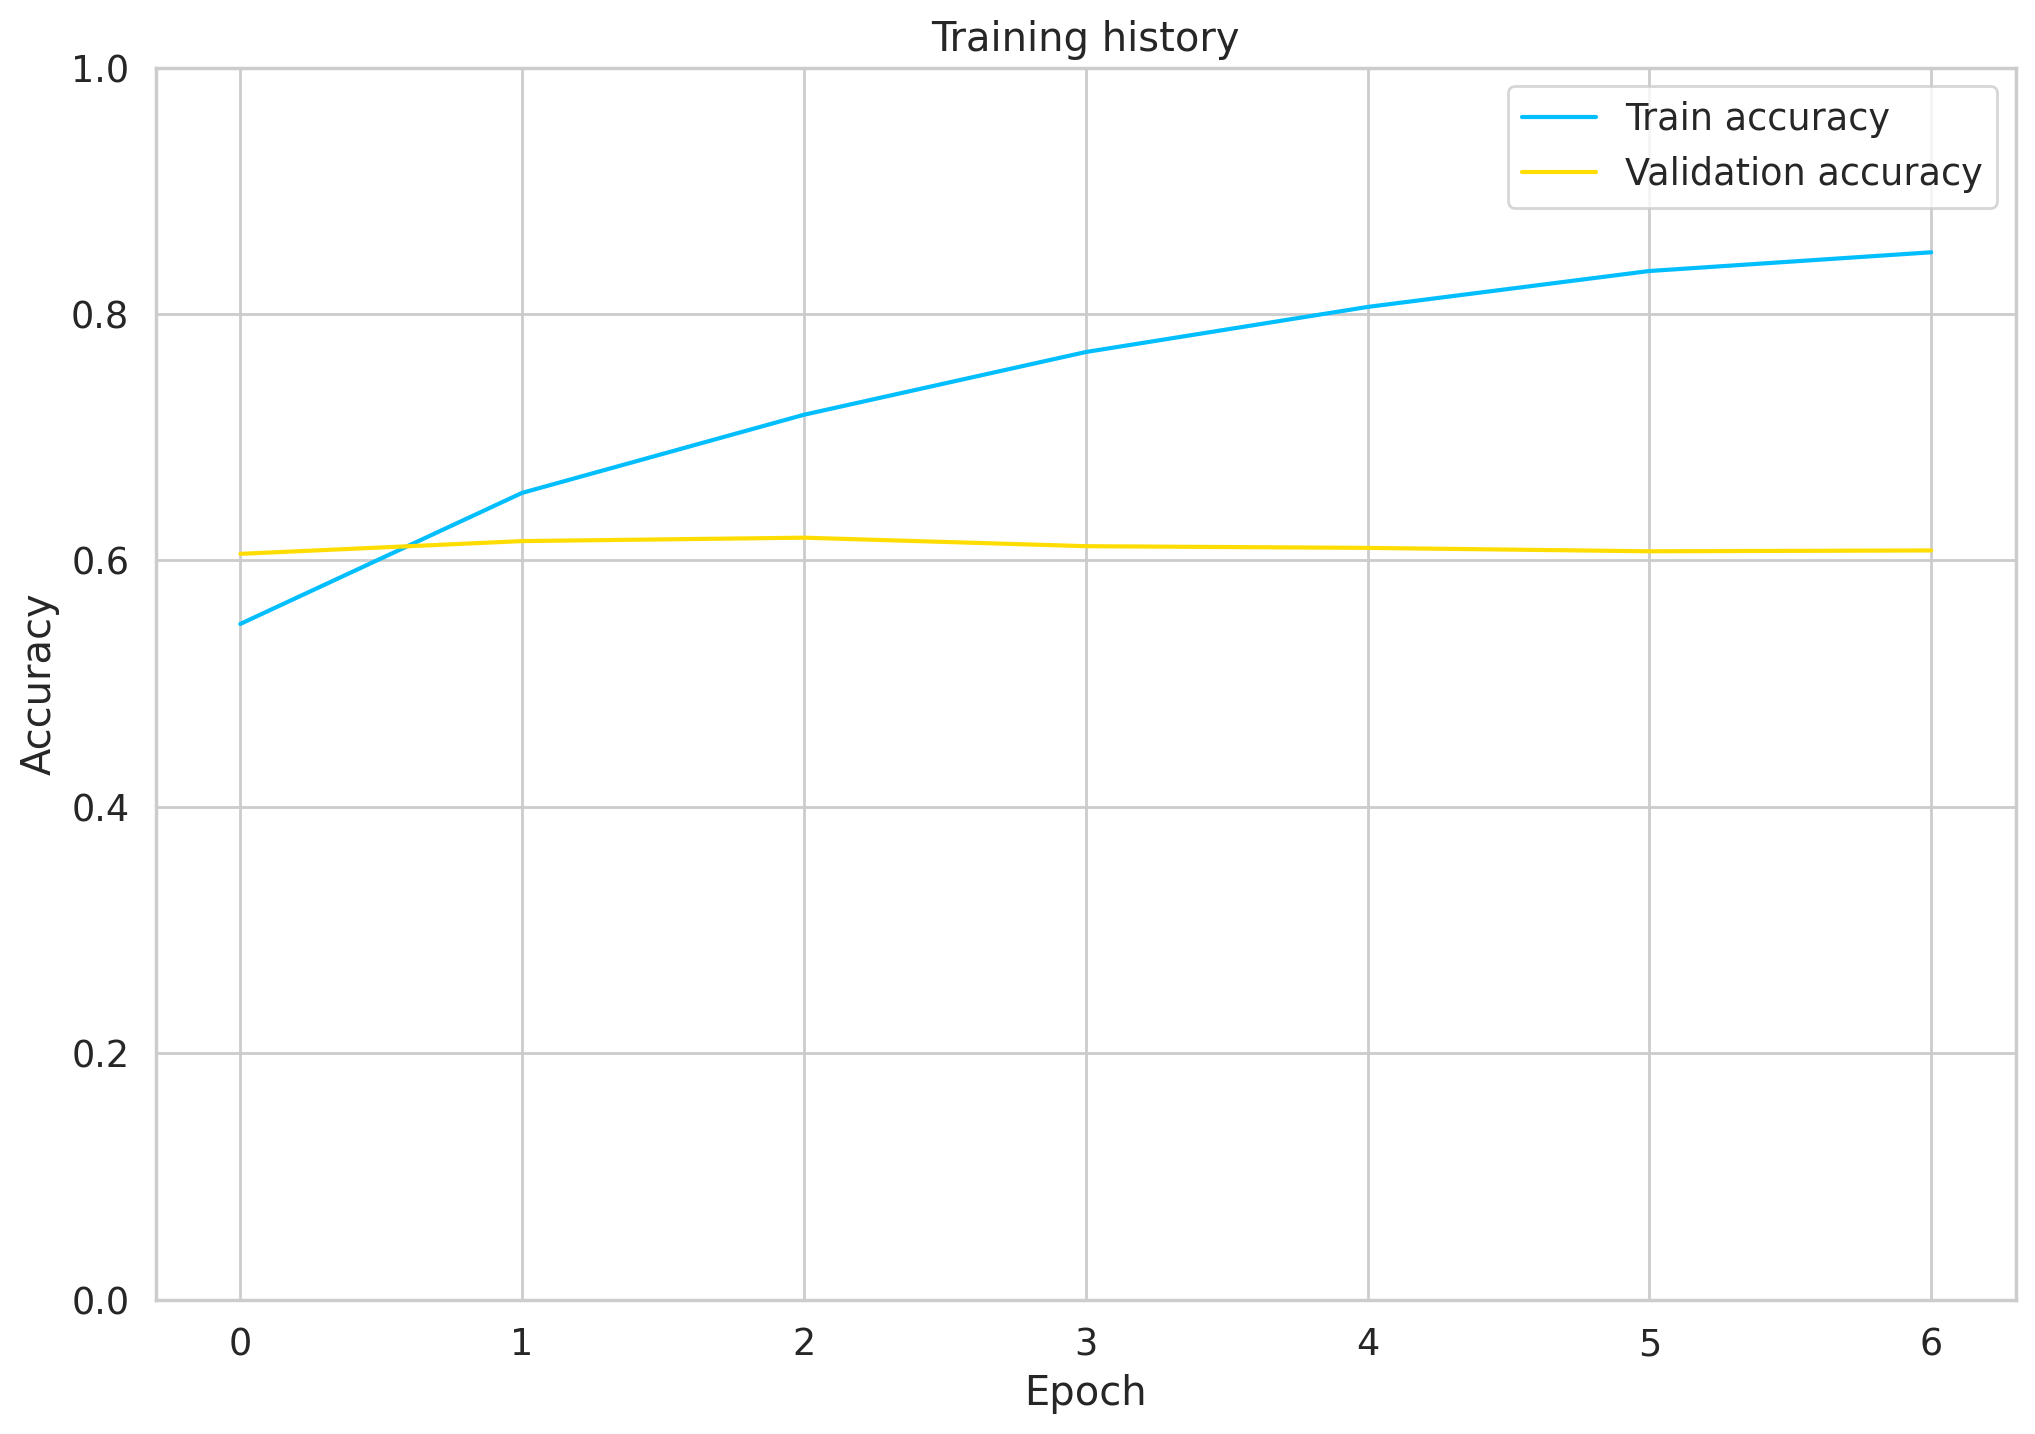

In [41]:
#Plot for train and val accuracy
plt.plot(new_training_acc, label='Train accuracy')
plt.plot(new_validation_acc, label='Validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

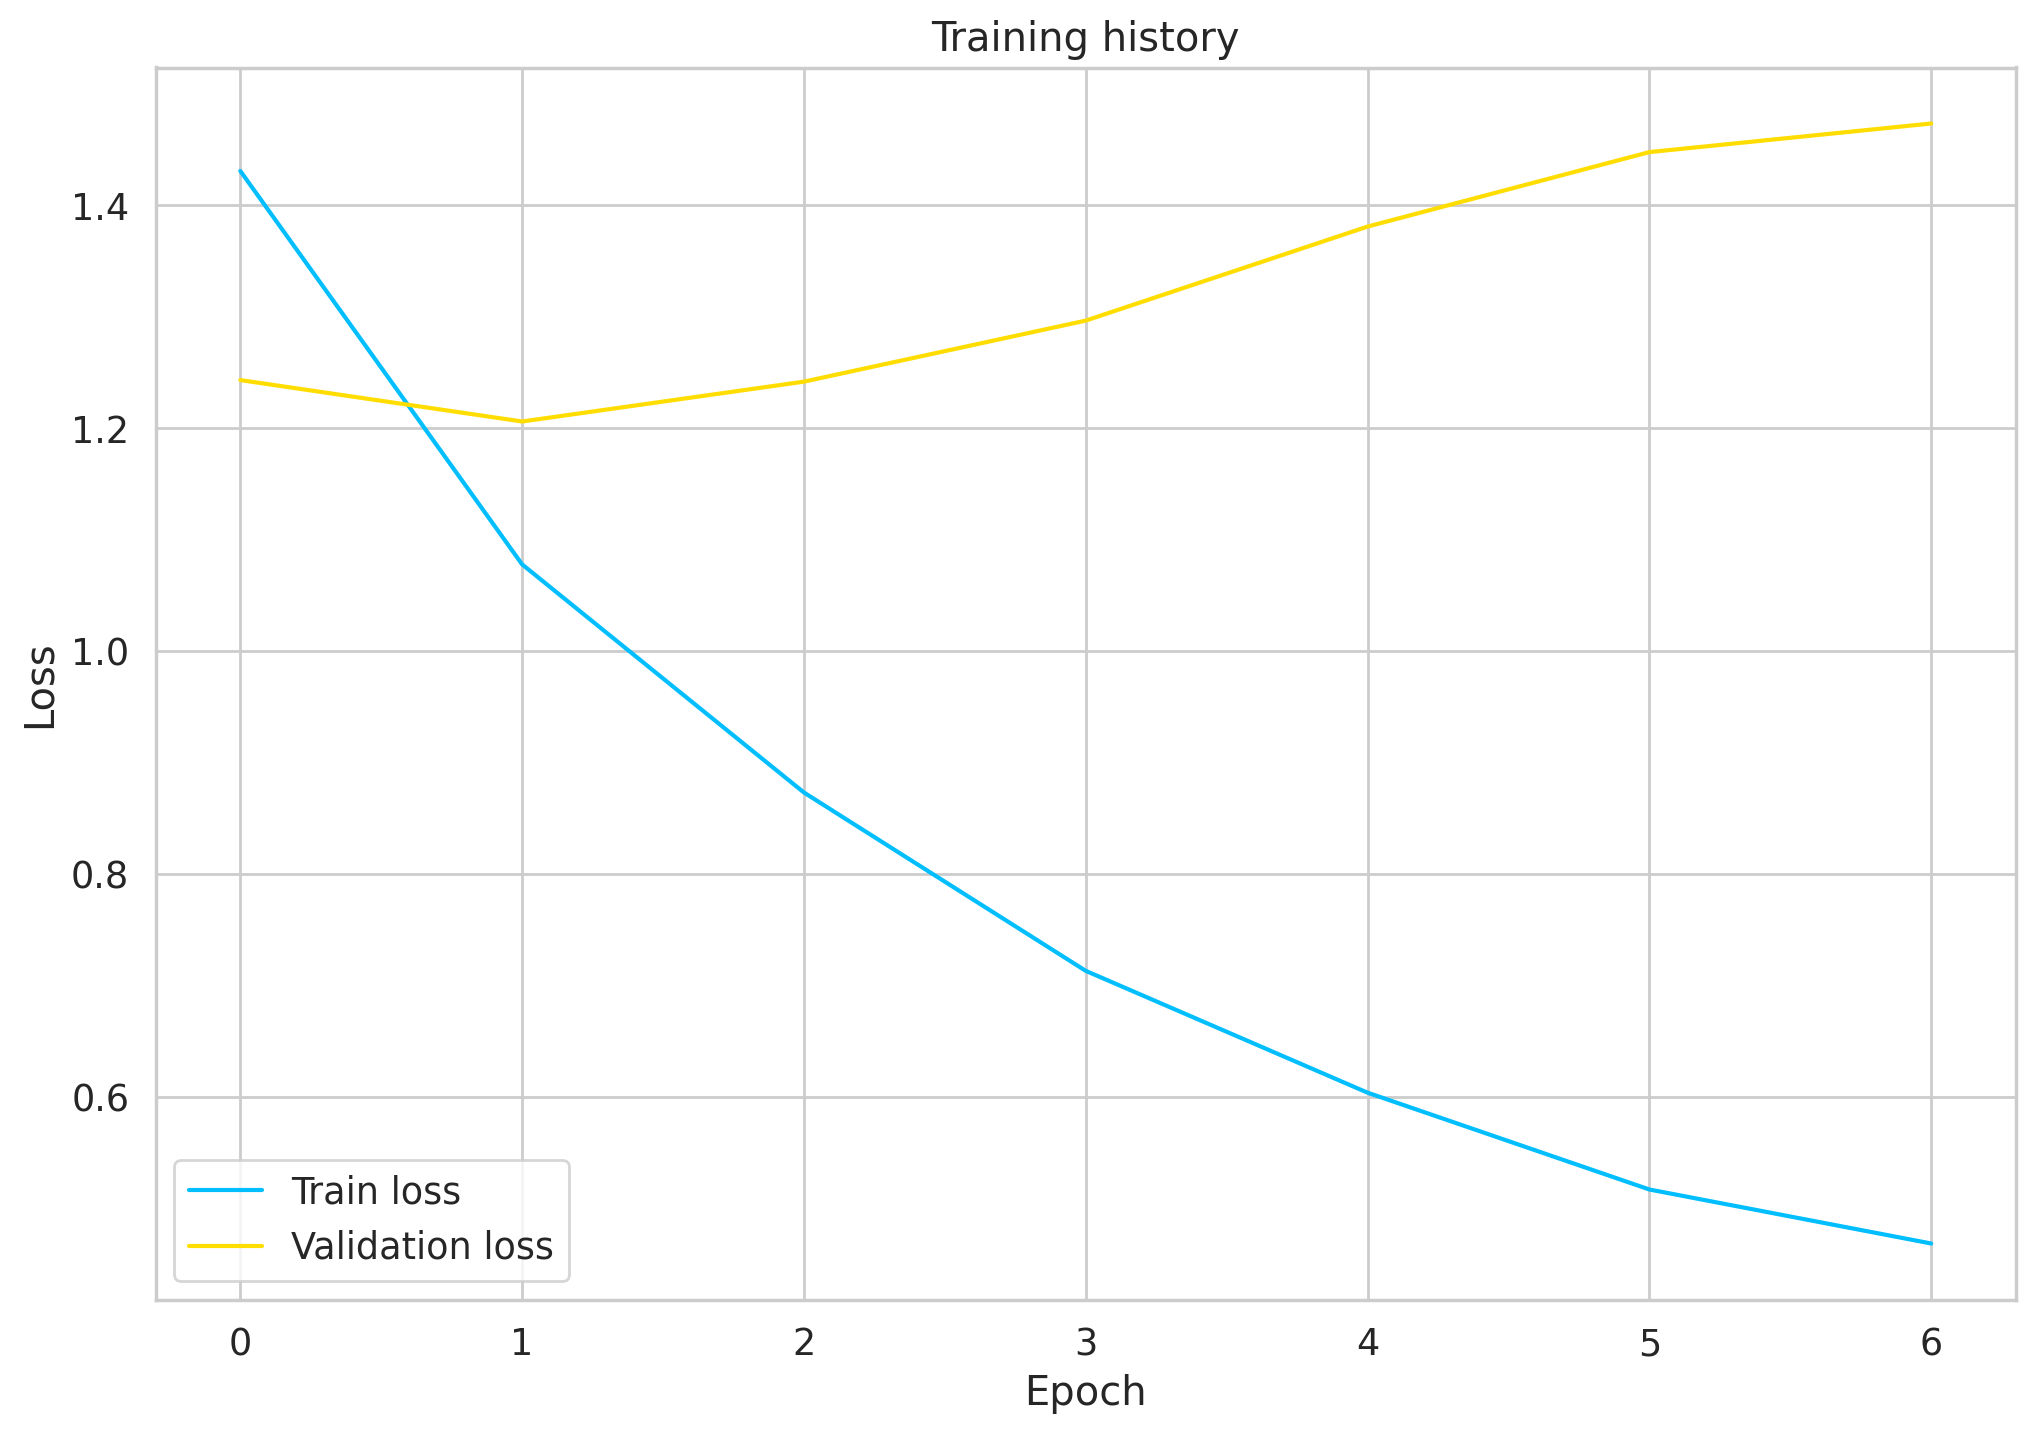

In [42]:
#Plot for train and val loss
plt.plot(training_loss, label='Train loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();

In [43]:
#Calculate accuracy on test data
test_acc, _ = evaluation(model_bert,test_data_loader,loss_fn,device,len(df_test))
test_acc.item()

100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.30it/s]


0.6082758620689654

In [44]:
#Code for prediction on test data
def predictions(model, data_loader):
  model = model.eval()
  review_texts = [] #input sequence
  predictions = [] #predictions obtained
  prediction_probs = [] #list of pred probabilities
  real_values = [] #real labels
  with torch.no_grad():
    for element in data_loader:
      texts = element["Legal_text"] #input text sequence 
      input_ids = element["input_ids"].to(device) #getting encoded sequence
      attention_mask = element["attention_mask"].to(device) #gettting attention mask
      targets = element["targets"].to(device) #Actual labels
      outputs = model(input_ids=input_ids,attention_mask=attention_mask)
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [45]:
y_review_texts, y_pred, y_pred_probs, y_test = predictions(model_bert,test_data_loader)

In [46]:
#Code to get Classification Report
print(classification_report(y_test, y_pred, target_names=labels_set))

                precision    recall  f1-score   support

         ratio       0.20      0.19      0.19        27
      preamble       0.63      0.63      0.63       200
pre_not_relied       0.00      0.00      0.00         9
           fac       0.62      0.64      0.63       285
arg_respondent       0.39      0.16      0.23        44
         issue       0.73      0.50      0.59        16
           rpc       0.71      0.75      0.73        52
           rlc       0.50      0.37      0.42        38
arg_petitioner       0.46      0.39      0.42        79
      analysis       0.64      0.72      0.67       518
          none       0.76      0.69      0.72        81
    pre_relied       0.41      0.43      0.42        72
           sta       0.65      0.38      0.48        29

      accuracy                           0.61      1450
     macro avg       0.51      0.45      0.47      1450
  weighted avg       0.60      0.61      0.60      1450



In [47]:
labels_index = list(labels_set)
labels_columns = list(labels_set)

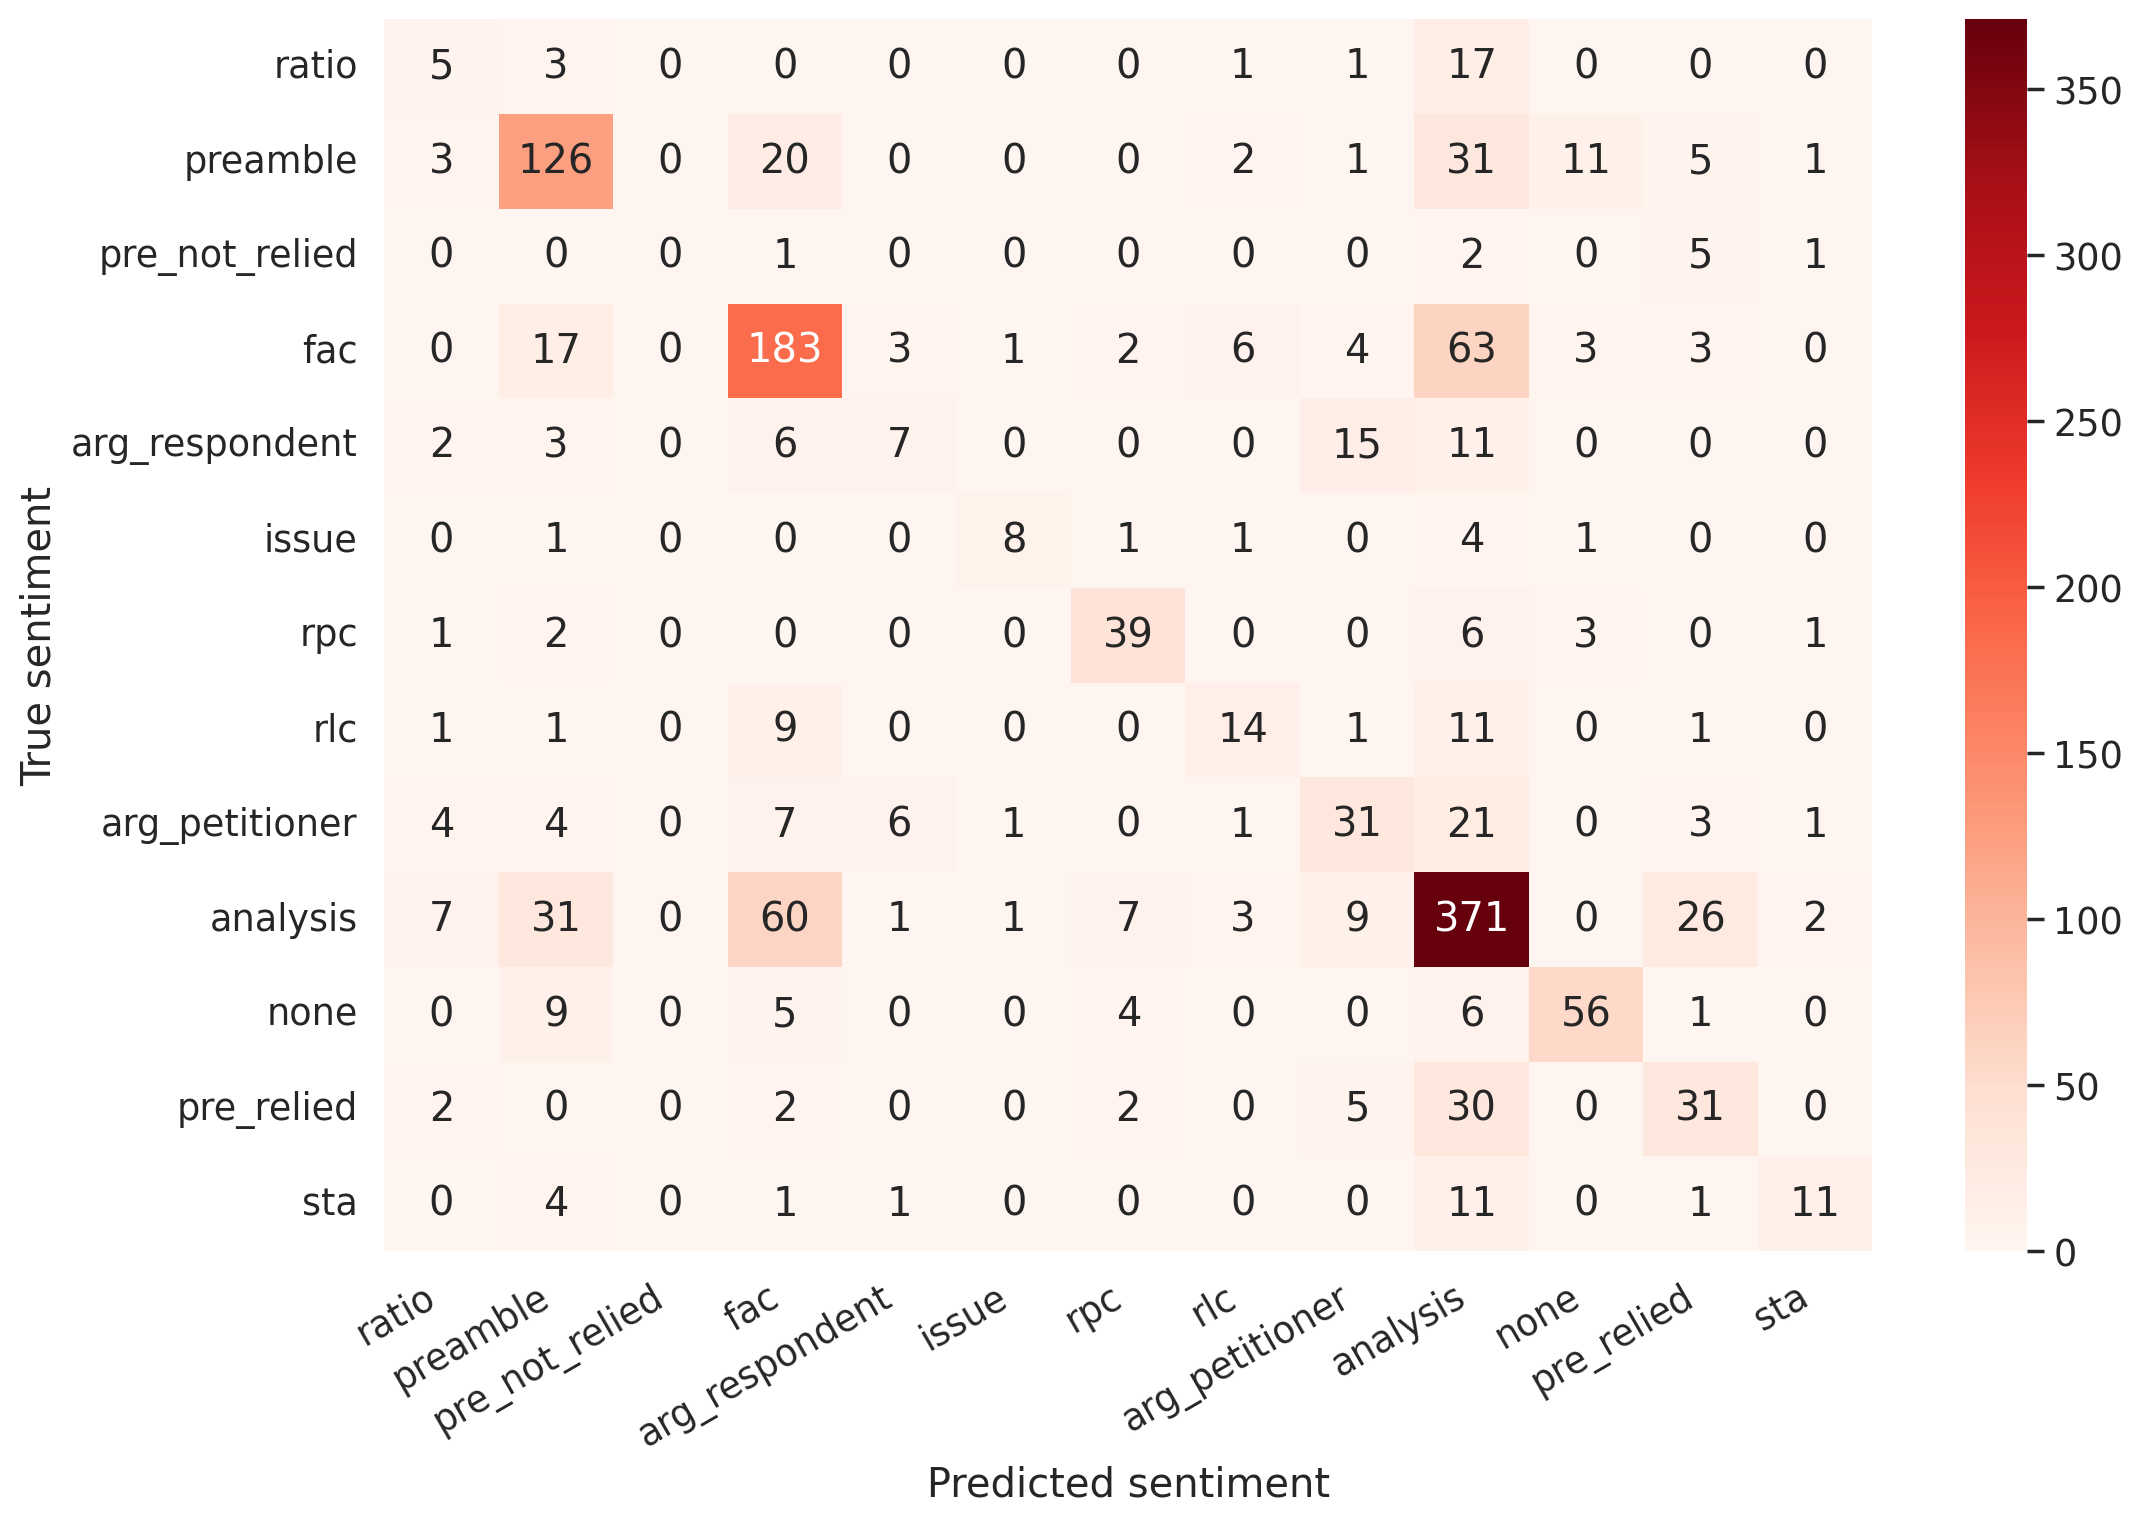

In [48]:
#Code to get the confusion matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Reds")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels_index, columns=labels_columns)
show_confusion_matrix(df_cm)

# BERT + LSTM Model

In [45]:
#Code of BERT+LSTM class
class BERT_LSTM(nn.Module):
  def __init__(self,em_dim,output_tokens,padding_index=0):
        super(BERT_LSTM,self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased',return_dict=False)
        self.drop = nn.Dropout(0.3)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, output_tokens)
        self.lstm=nn.LSTM(input_size=em_dim,hidden_size=self.bert.config.hidden_size,num_layers=1,batch_first=True,bidirectional=False)
        
  def forward(self,input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask)
        x=self.drop(pooled_output)
        out,hidden=self.lstm(x)
        h1=self.fc1(out)
        h2=h1.view(-1, h1.shape[-1])
        return h2

In [46]:
model = BERT_LSTM(768,len(labels_set)) # intializing the model
model = model.to(device) 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
# hyperparameters 
EPOCHS = 10
total_steps = len(train_data_loader) * EPOCHS
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
loss_fn = nn.CrossEntropyLoss().to(device)
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)

In [48]:
#Code to train and evaluate the model
from collections import defaultdict
history = defaultdict(list)

training_acc = [] #list to store training accuracies
training_loss =[] # list to store training loss
validation_acc = [] # list to store validation accuracys
validation_loss =[] # list to store validation losses

best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = training(model,train_data_loader,loss_fn,optimizer,device,scheduler,len(df_train))
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = evaluation(model,val_data_loader,loss_fn,device,len(df_val))
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  training_acc.append(train_acc)
  history['train_loss'].append(train_loss)
  training_loss.append(train_loss)
  history['val_acc'].append(val_acc)
  validation_acc.append(val_acc)
  history['val_loss'].append(val_loss)
  validation_loss.append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


100%|█████████████████████████████████████████| 816/816 [06:18<00:00,  2.15it/s]


Train loss 1.644194250743763 accuracy 0.4918158469735884


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.15it/s]


Val   loss 1.4400756307270215 accuracy 0.556935817805383

Epoch 2/10
----------


100%|█████████████████████████████████████████| 816/816 [06:19<00:00,  2.15it/s]


Train loss 1.3203249184378223 accuracy 0.6001456664238893


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.12it/s]


Val   loss 1.3364954409391985 accuracy 0.5983436853002071

Epoch 3/10
----------


100%|█████████████████████████████████████████| 816/816 [06:19<00:00,  2.15it/s]


Train loss 1.1087099532140237 accuracy 0.6733622110629816


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.13it/s]


Val   loss 1.3455840763838396 accuracy 0.6059351276742582

Epoch 4/10
----------


100%|█████████████████████████████████████████| 816/816 [06:19<00:00,  2.15it/s]


Train loss 0.9495945516243285 accuracy 0.7282937861770231


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.13it/s]


Val   loss 1.3895688329053961 accuracy 0.6024844720496895

Epoch 5/10
----------


100%|█████████████████████████████████████████| 816/816 [06:17<00:00,  2.16it/s]


Train loss 0.8313607952977512 accuracy 0.7634453942576762


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.17it/s]


Val   loss 1.4347628329111182 accuracy 0.5914423740510697

Epoch 6/10
----------


100%|█████████████████████████████████████████| 816/816 [06:16<00:00,  2.17it/s]


Train loss 0.7350833487934342 accuracy 0.7902020163299728


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.19it/s]


Val   loss 1.4705919856610505 accuracy 0.5900621118012422

Epoch 7/10
----------


100%|█████████████████████████████████████████| 816/816 [06:20<00:00,  2.14it/s]


Train loss 0.6602897692069996 accuracy 0.8094069843216928


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.08it/s]


Val   loss 1.4989845506522967 accuracy 0.587991718426501

Epoch 8/10
----------


100%|█████████████████████████████████████████| 816/816 [06:21<00:00,  2.14it/s]


Train loss 0.5966695653018999 accuracy 0.8292636178939702


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.09it/s]


Val   loss 1.547870853672857 accuracy 0.6162870945479642

Epoch 9/10
----------


100%|█████████████████████████████████████████| 816/816 [06:19<00:00,  2.15it/s]


Train loss 0.5517044266978023 accuracy 0.8421819296967838


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.13it/s]


Val   loss 1.5924484574276467 accuracy 0.6197377501725327

Epoch 10/10
----------


100%|█████████████████████████████████████████| 816/816 [06:15<00:00,  2.17it/s]


Train loss 0.5180870389072773 accuracy 0.8521869130218117


100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.19it/s]

Val   loss 1.5831535769545513 accuracy 0.6073153899240856



In [49]:
new_training_acc =[]
for i in training_acc:
  x= i.to("cpu") 
  final = x.numpy()
  new_training_acc.append(final)

new_validation_acc =[]
for i in validation_acc:
  x= i.to("cpu") 
  final = x.numpy()
  new_validation_acc.append(final)

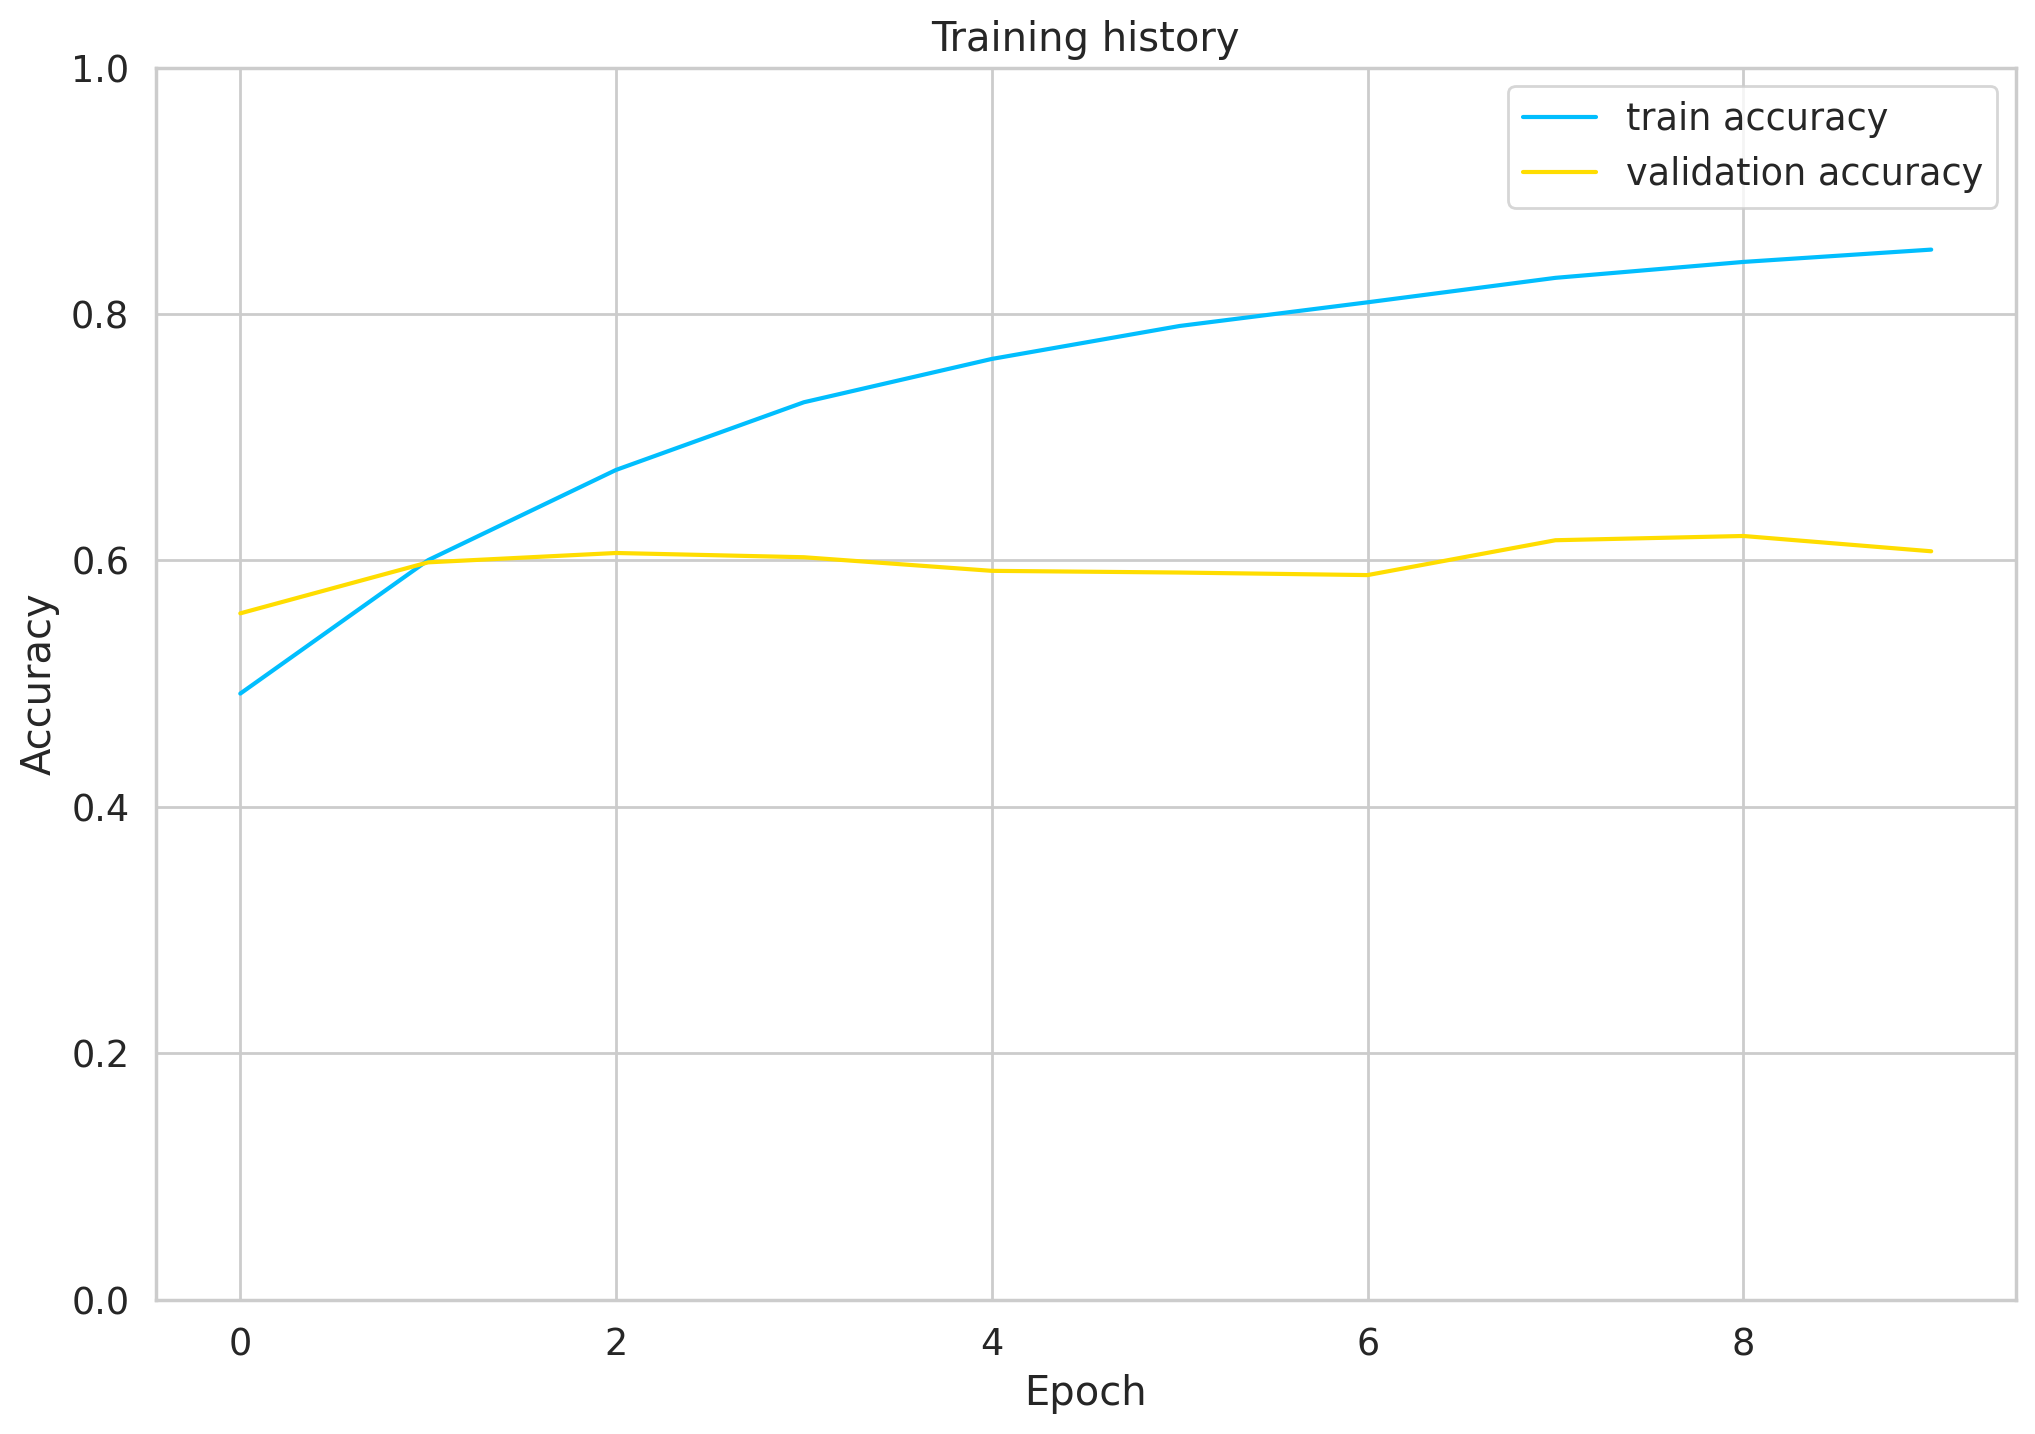

In [50]:
#Plot for train and val accuracy
plt.plot(new_training_acc, label='train accuracy')
plt.plot(new_validation_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

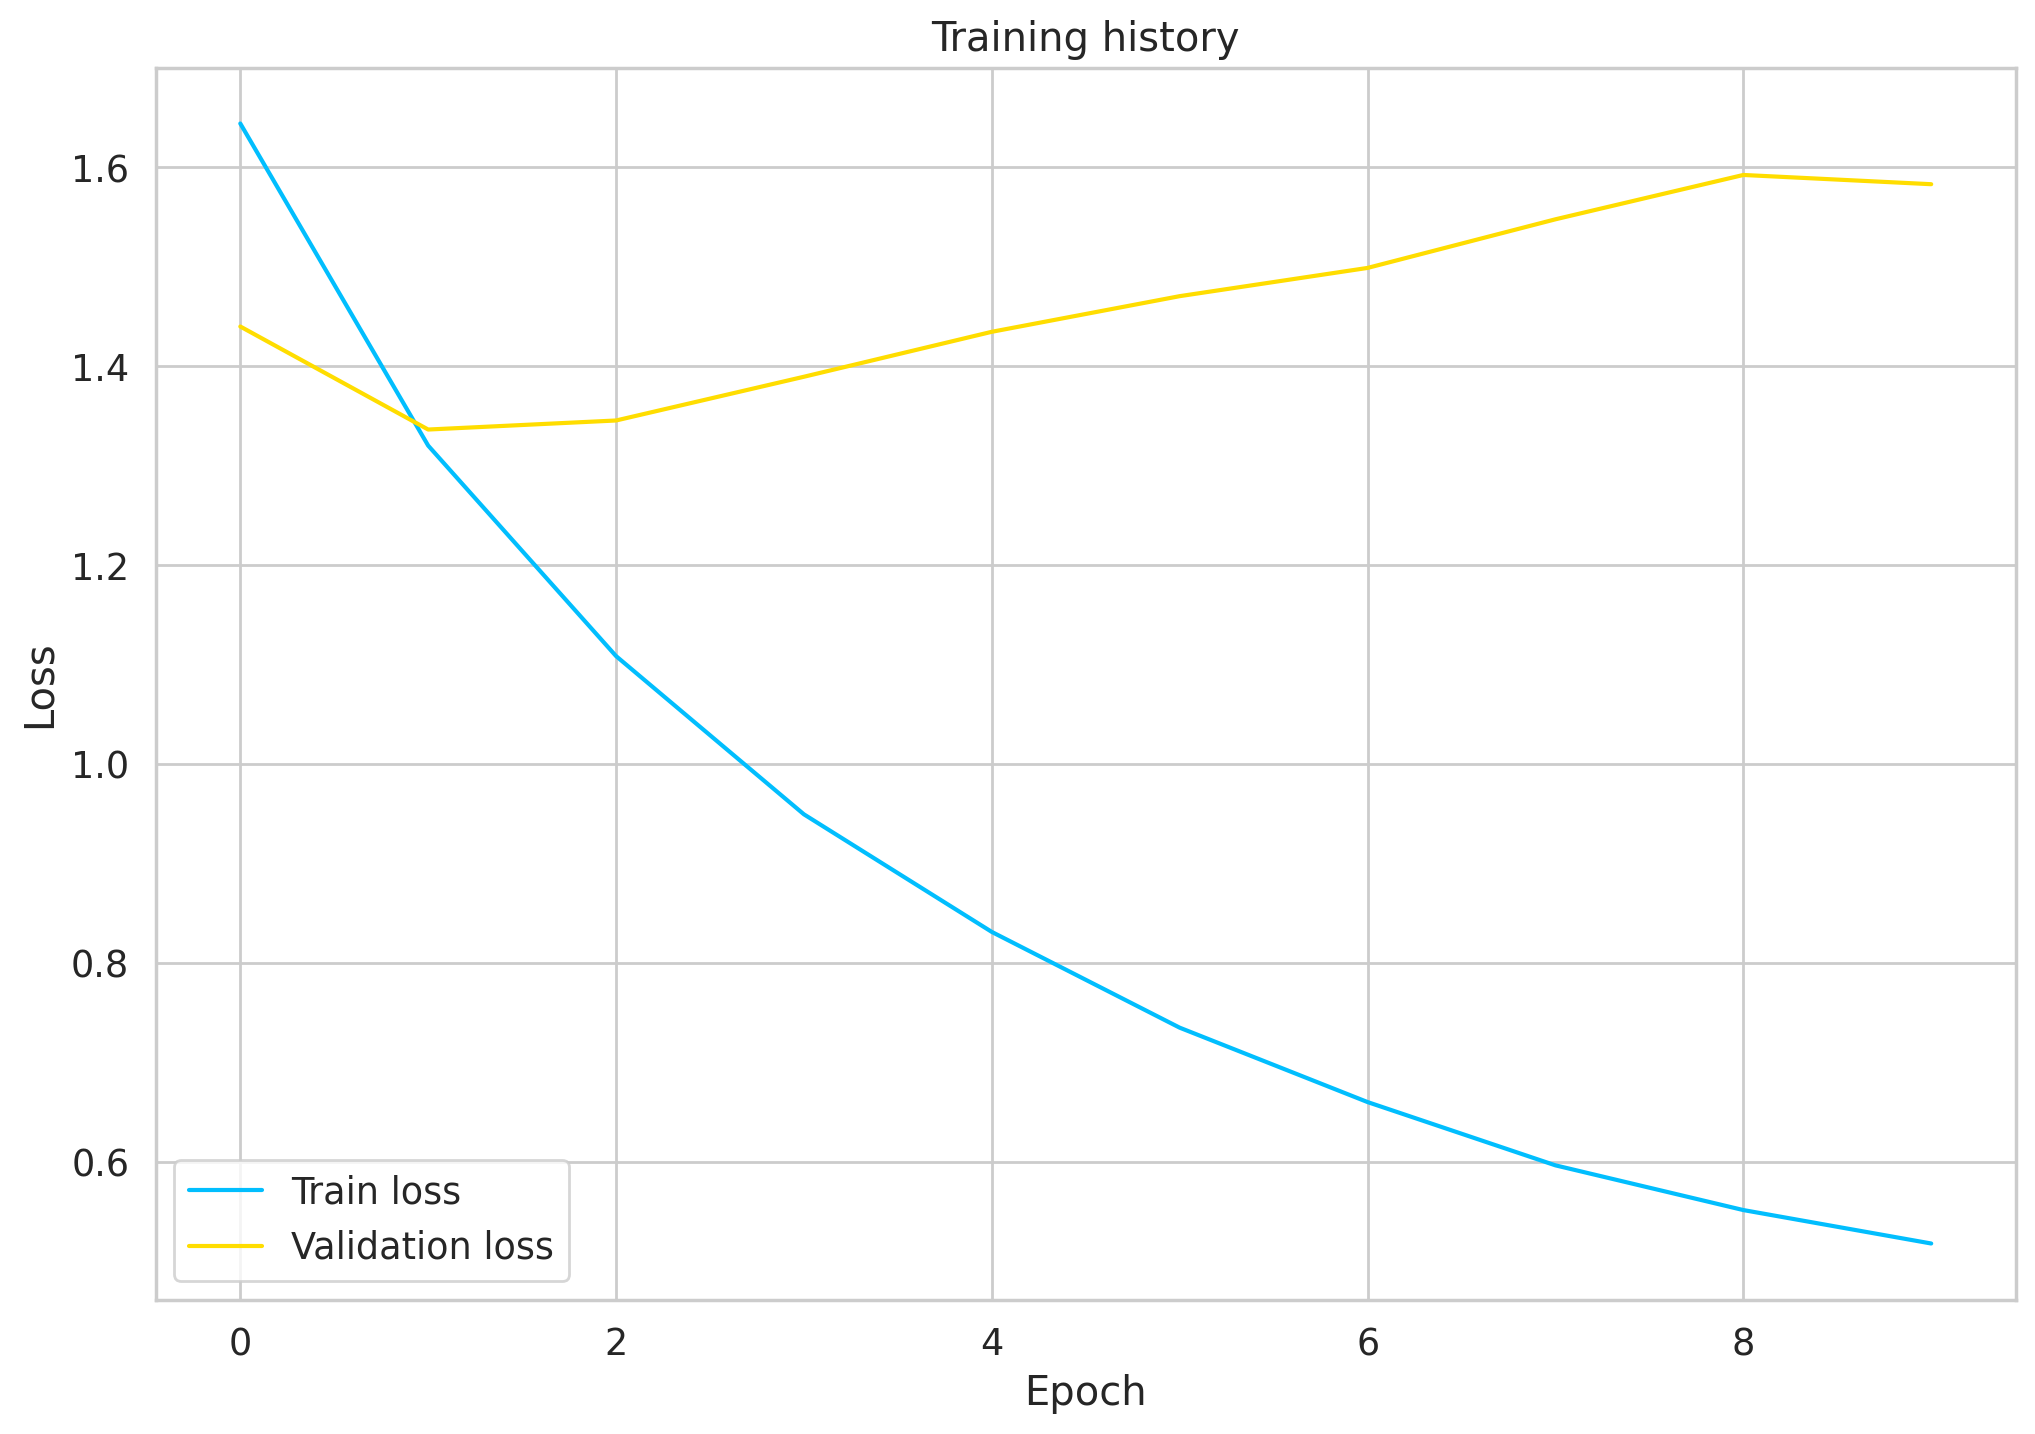

In [51]:
#Plot for train and val loss
plt.plot(training_loss, label='Train loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend();

In [52]:
test_acc, _ = evaluation(model,test_data_loader,loss_fn,device,len(df_test))
test_acc.item()

100%|███████████████████████████████████████████| 46/46 [00:07<00:00,  6.21it/s]


0.6027586206896551

In [53]:
y_review_texts, y_pred, y_pred_probs, y_test = predictions(model,test_data_loader)

In [54]:
#Code to get Classification Report
print(classification_report(y_test, y_pred, target_names=labels_set))

                precision    recall  f1-score   support

      analysis       0.64      0.72      0.68       518
      preamble       0.65      0.64      0.64       200
    pre_relied       0.39      0.44      0.42        72
           rpc       0.67      0.67      0.67        52
         issue       0.80      0.50      0.62        16
arg_petitioner       0.45      0.47      0.46        79
           sta       0.65      0.45      0.53        29
pre_not_relied       0.00      0.00      0.00         9
         ratio       0.04      0.04      0.04        27
arg_respondent       0.17      0.02      0.04        44
          none       0.78      0.70      0.74        81
           rlc       0.19      0.16      0.17        38
           fac       0.64      0.64      0.64       285

      accuracy                           0.60      1450
     macro avg       0.47      0.42      0.43      1450
  weighted avg       0.59      0.60      0.59      1450



In [55]:
labels_index = list(labels_set)
labels_columns = list(labels_set)

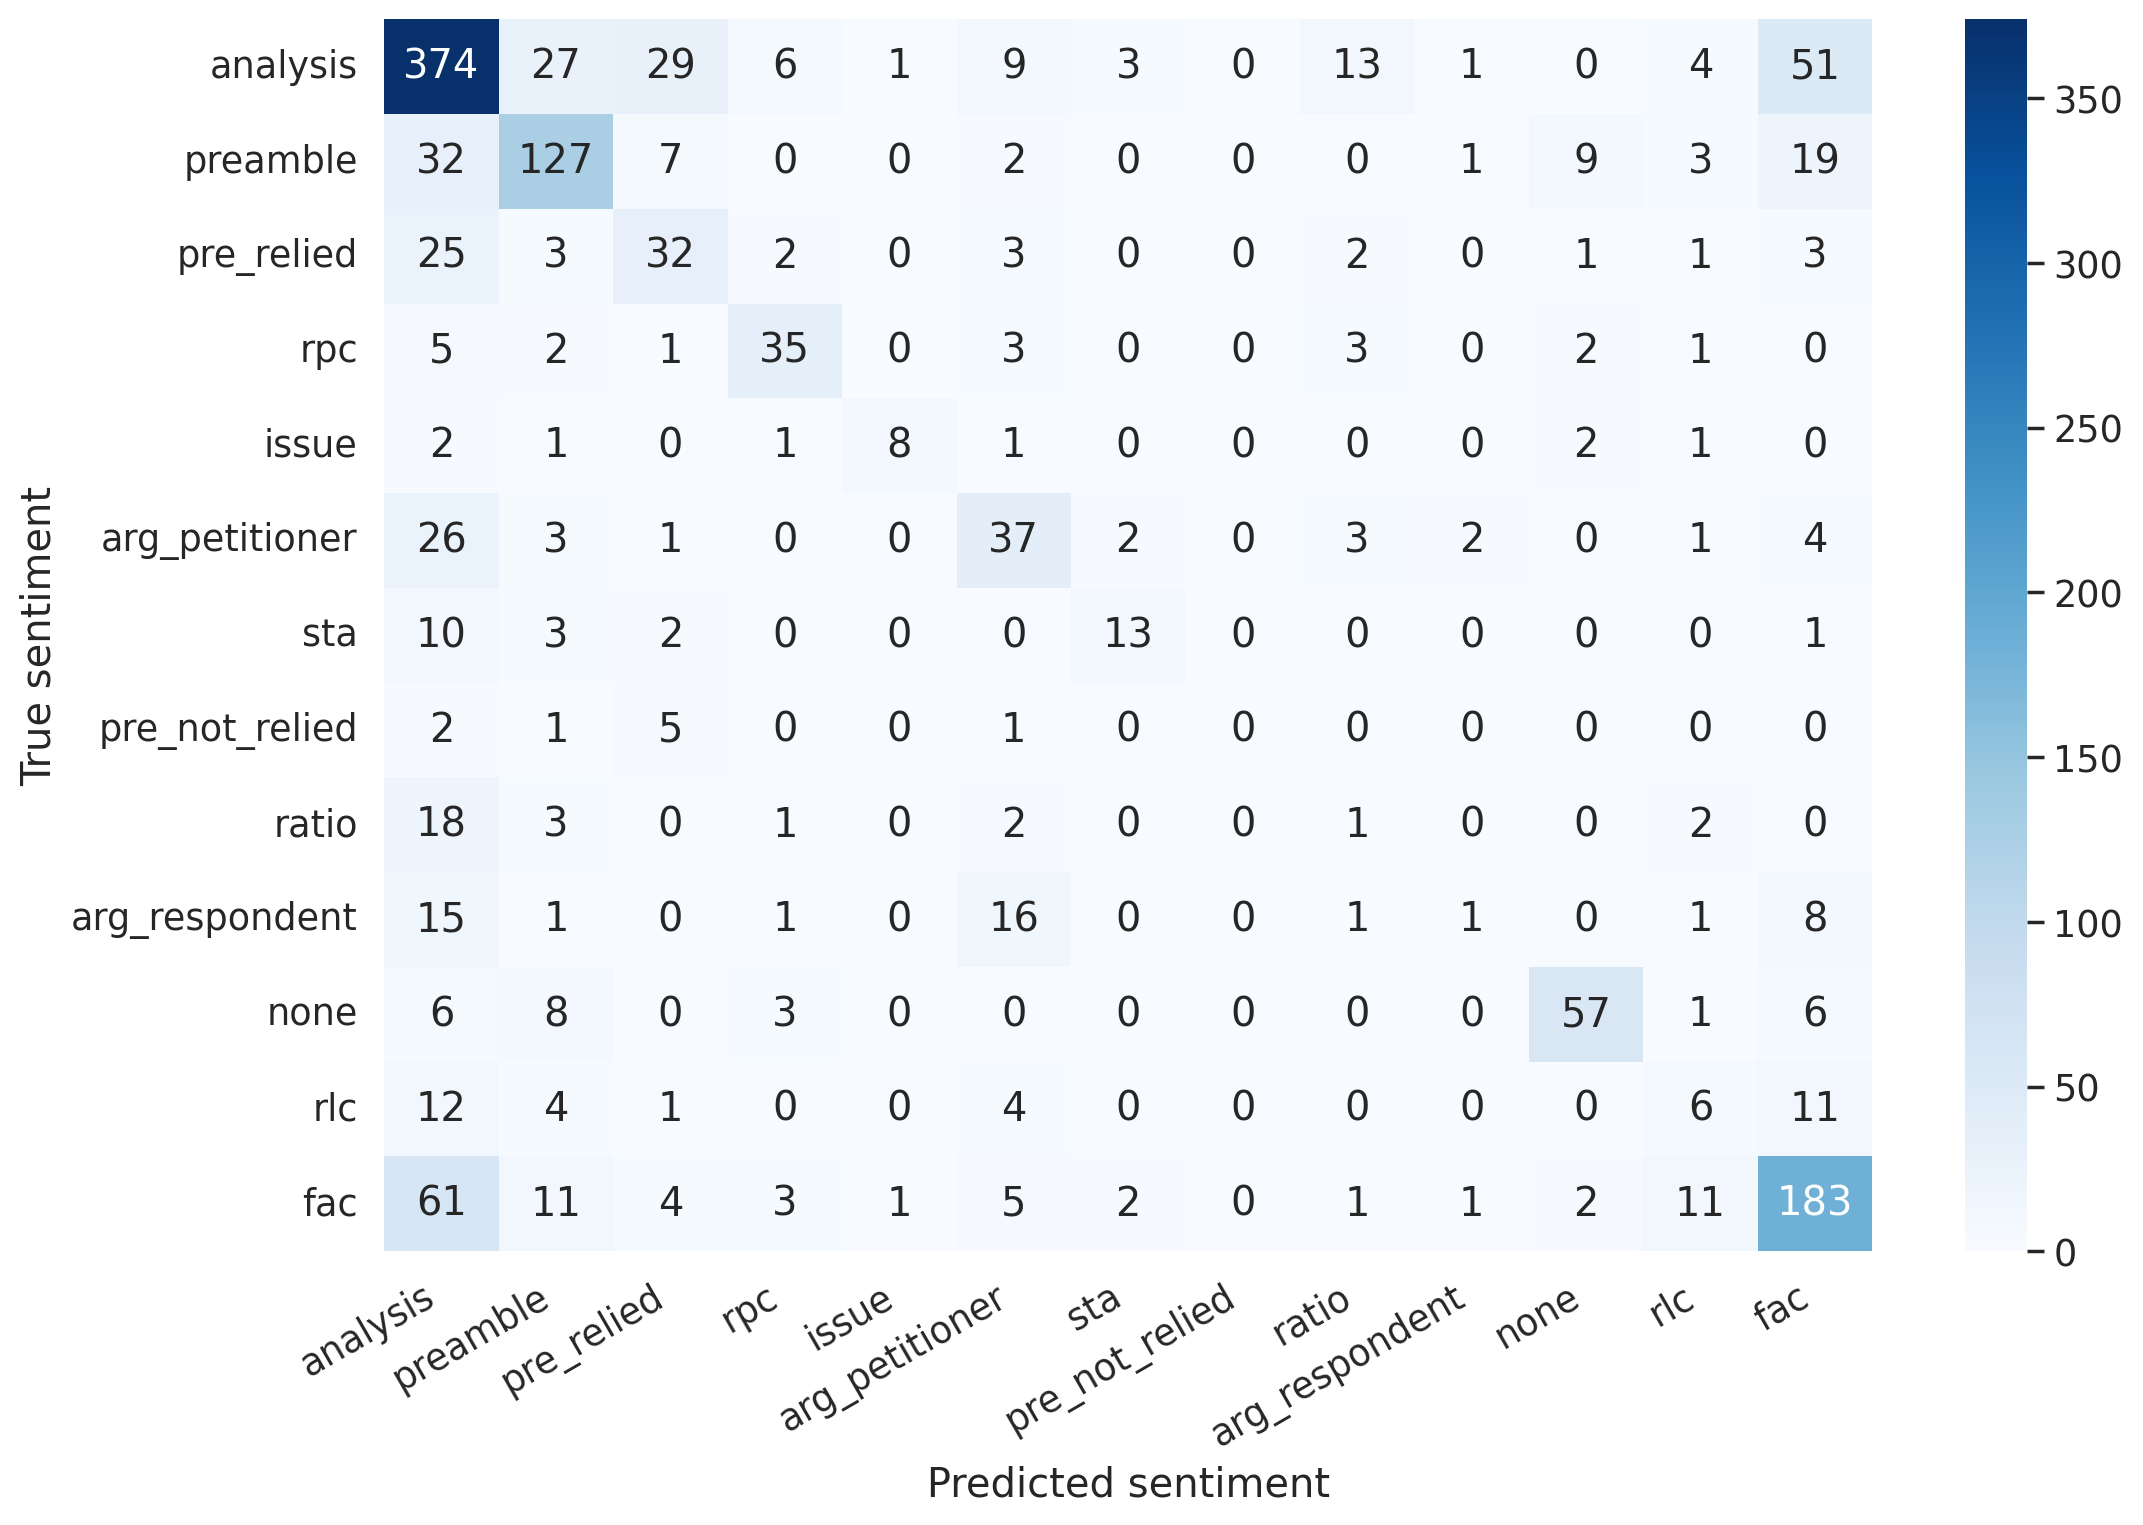

In [56]:
#Code to get confusion matrix
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=labels_index, columns=labels_columns)
show_confusion_matrix(df_cm)